I've already transformed raw column timestamp in a timestamp and adjusted putting the real NaN.  
Now I want to go deep into the information that I can extract from the timestamp

Starting point: https://www.shaped.ai/blog/decoding-timestamps-time-based-feature-engineering-for-search-recs

In [1]:
import pandas as pd
from src.preprocessing import Preprocessor

prep = Preprocessor()
prep.full_prep()
news_df = prep.df

In [2]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79996 entries, 0 to 79996
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source     79996 non-null  object        
 1   title      79996 non-null  object        
 2   article    79995 non-null  object        
 3   page_rank  79996 non-null  int64         
 4   timestamp  52246 non-null  datetime64[ns]
 5   label      79996 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 4.3+ MB


In [ ]:
news_df['dayofweek'] = news_df['timestamp'].dt.day_of_week
news_df['month'] = news_df['timestamp'].dt.month
news_df['hour'] = news_df['timestamp'].dt.hour
news_df['year'] = news_df['timestamp'].dt.year

In [4]:
news_df

,source,title,article,page_rank,timestamp,label,dayofweek,month,hour,year
Id,,,,,,,,,,
0,AllAfrica.com,OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd,THE Organisation of Petroleum Exporting Countr...,5,2004-09-16 22:39:53,5,3.0,9.0,22.0,2004.0
1,Xinhua,Yearender: Mideast peace roadmap reaches dead-...,Looking back at the major events that took pla...,5,2004-12-17 19:01:14,0,4.0,12.0,19.0,2004.0
2,Yahoo,Battleground Dispatches for Oct. 5 \\n (CQP...,CQPolitics.com - Here are today's Battleground...,5,2006-10-05 18:42:29,0,3.0,10.0,18.0,2006.0
3,BBC,Air best to resuscitate newborns,Air rather than oxygen should be used to resus...,5,NaT,0,NaN,NaN,NaN,NaN
4,Yahoo,High tech German train crash kills at least on...,"<p><a href=""http://us.rd.yahoo.com/dailynews/r...",5,2006-09-22 17:28:57,0,4.0,9.0,17.0,2006.0
...,...,...,...,...,...,...,...,...,...,...
79992,Yahoo,Italy's embattled Prodi faces vote of confiden...,"<p><a href=""http://us.rd.yahoo.com/dailynews/r...",5,2008-01-23 11:39:35,0,2.0,1.0,11.0,2008.0
79993,All-Baseball.com,"Ding Dong, the Deal is Dead","As yesterday began, there was widespread antic...",5,NaT,4,NaN,NaN,NaN,NaN
79994,Yahoo,Two bombs discovered in Sardinia after Berlusc...,AFP - Police discovered two bombs near the Sar...,5,NaT,0,NaN,NaN,NaN,NaN


I want to see if there are correlation between these new features and the labels

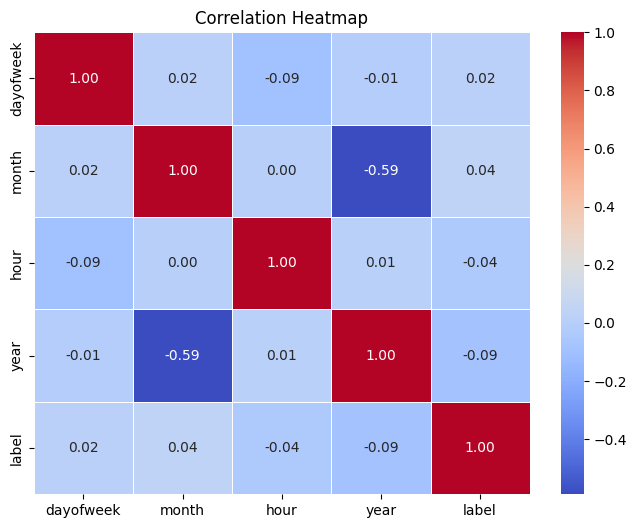

In [5]:
time_cols = ['dayofweek', 'month', 'hour', 'year']
corr = news_df[time_cols + ['label']].corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

It seems that no relation is present, but I still think that they can be valuable.  
Other ways to see and test correlation between label and this time cols: https://towardsdatascience.com/contingency-tables-chi-squared-and-cramers-v-ada4f93ec3fd/ 

dayofweek   0.0   1.0   2.0   3.0   4.0   5.0   6.0
label                                              
0          2161  2388  2464  2685  2349  1714  1645
1          1061  1306  1231  1404  1344   581   374
2          1171  1568  1584  1650  1514   742   469
3           888   925   951  1018  1024   648   480
4           686   634   665   764   751   633   713
5          1200  1341  1184  1425  1240   834   911
6           211   354   345   372   332   176   136
p-value: 1.2725585991393446e-160
month  1.0   2.0   3.0   5.0   6.0   7.0   8.0   9.0   10.0  11.0  12.0
label                                                                  
0      1842  1984   575   394  1300  1028   911  2880  1403   849  2240
1       914   913   276   173   551   477   389  1212   782   534  1080
2       972  1458   375   286  1094   440   345  1598   692   345  1093
3       694   728   162    93   379   314   383  1006   794   492   889
4       559   541   123    77   285   260   355   809   593   440  

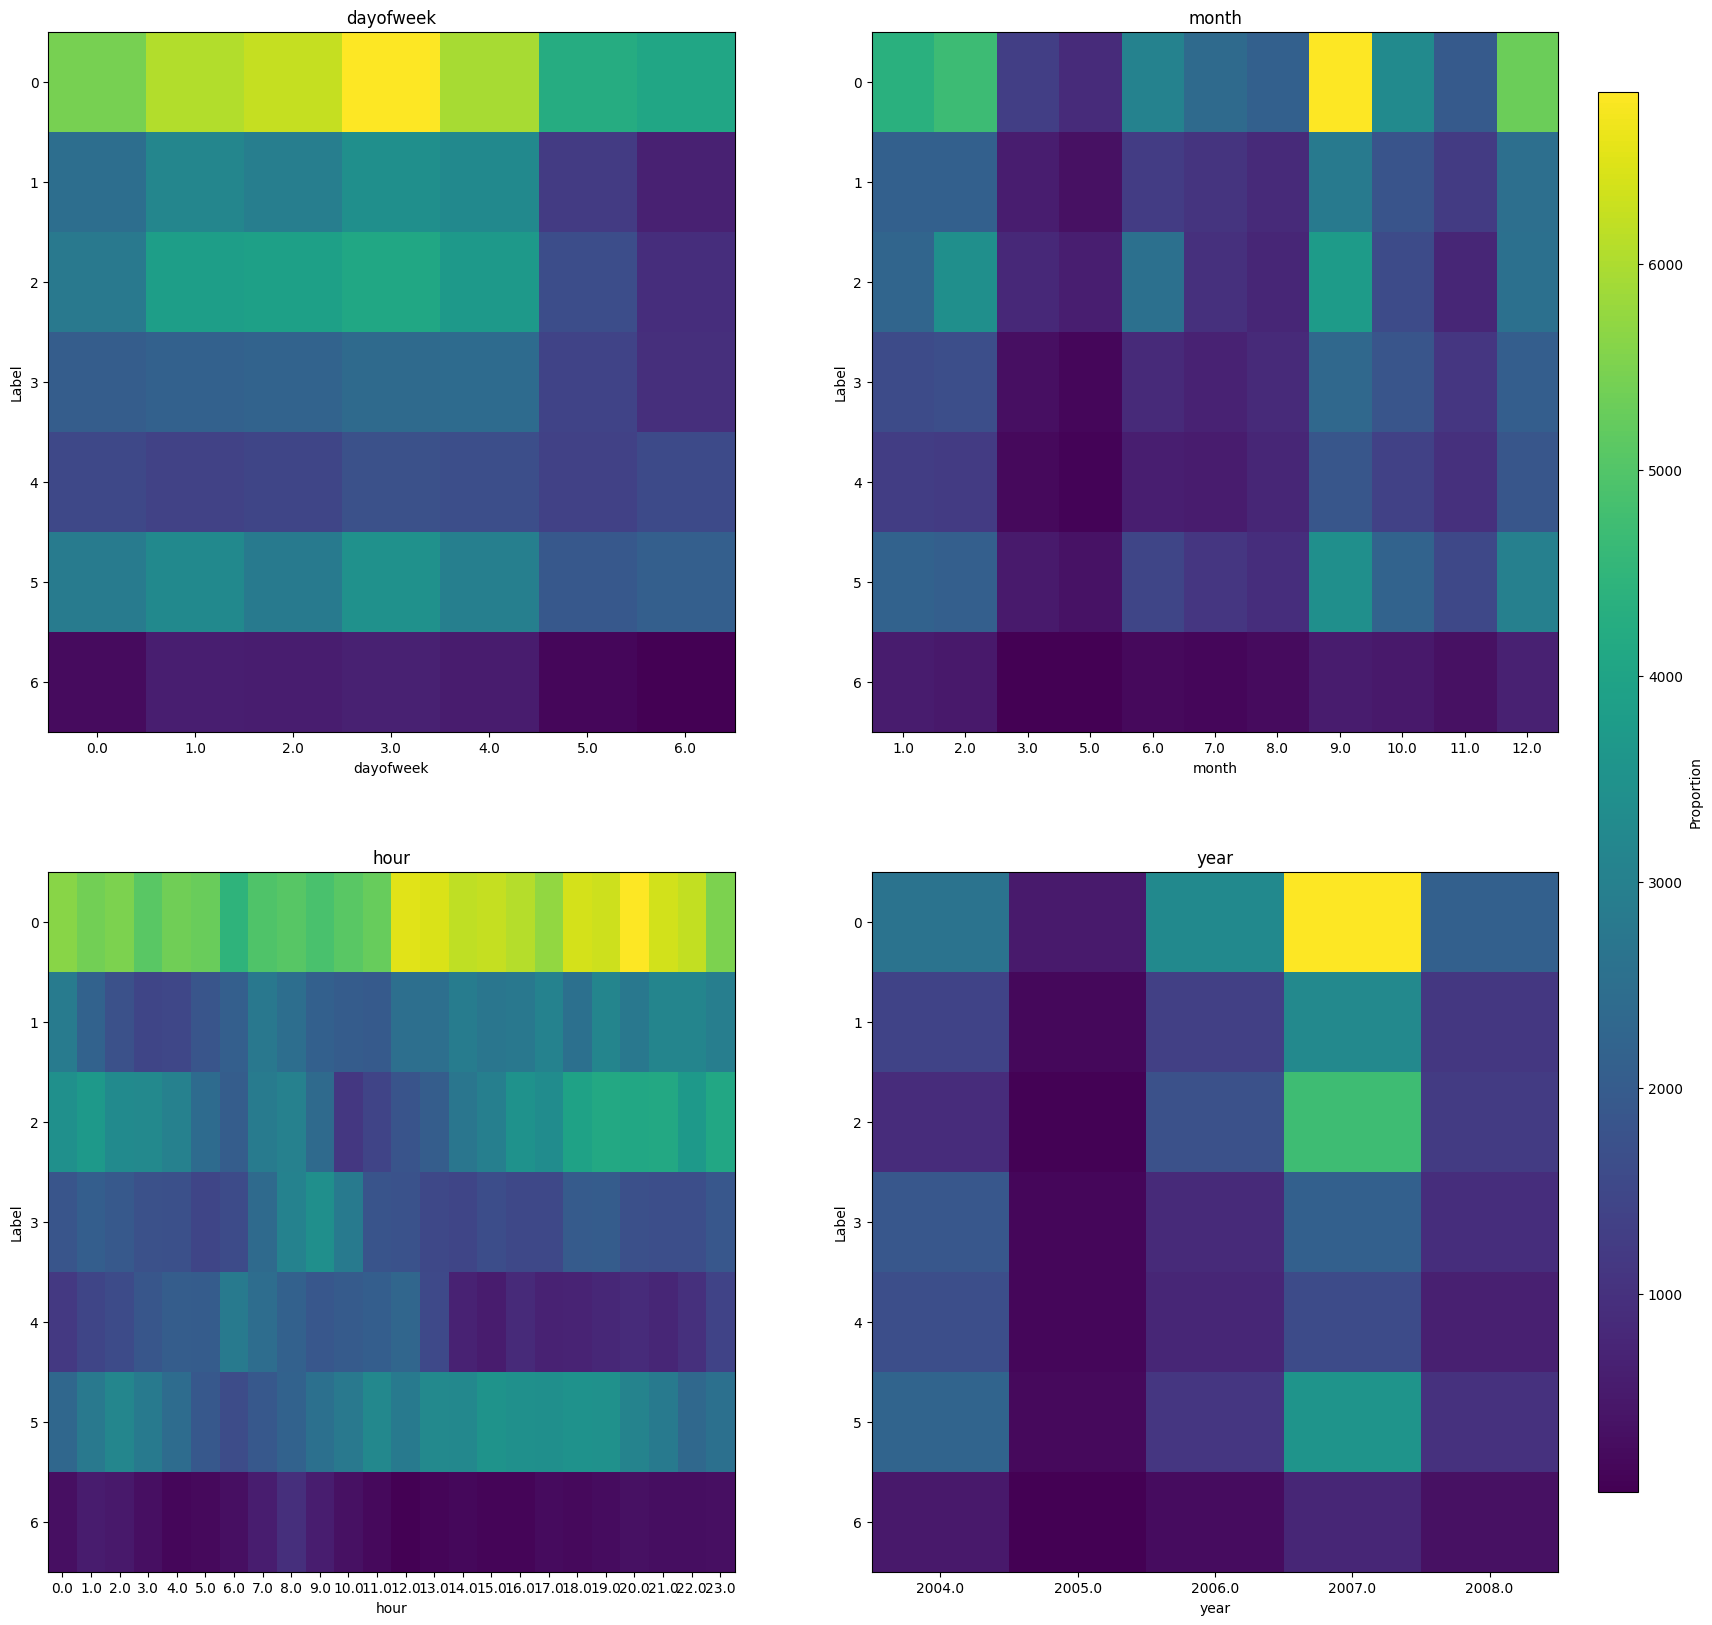

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, time_col in enumerate(time_cols):

    # creation of the contingency table: is a table that displays the multivariate frequency distribution of the variables
    # Intuitvely, they provide a basic picture of the interrelation between two variables (https://en.wikipedia.org/wiki/Contingency_table)
    ct = pd.crosstab(news_df["label"], news_df[time_col])

    # Pearson's chi-squared test: evaluate how likely it is that any observed difference
    # between the variables arose by chance (https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
    # In this test, H0: the two variables are independnt
    chi2, p, dof, expected = chi2_contingency(ct)

    print('='*50)
    print(ct)
    print(f'p-value: {p}')

    print('='*50)


    ax = axes[i // 2, i % 2]
    im = ax.imshow(ct, aspect="auto")

    ax.set_title(time_col)
    ax.set_xlabel(time_col)
    ax.set_ylabel("Label")

    ax.set_xticks(range(ct.shape[1]))
    ax.set_xticklabels(ct.columns)
    ax.set_yticks(range(ct.shape[0]))
    ax.set_yticklabels(ct.index)

# These lines are for the colorbar on the right 
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cax, label="Proportion")

plt.show()


Very small values of p-value means that a correlation do exist, so I will keep these columns.  

For now I will stop here; there are plenty of others things to extract (weekend, season, etc...) and also for example looking if it makes sense to do a cyclical encoding (looking at label 0 in the matrices probably yes) but I want to build firstly a simple baseline.